## Example of social cue detection framework using transfer entropy
This is a basic demonstration of the social cue detection framework using transfer entropy based on the work published [here](https://doi.org/10.1145/3610977.3634933). This framework detects perceptible social cues during interactions as well as their directionality. In this demonstration, we're going to go through step by step the framework working on some manually generated data. The framework handles raw time-series data such as
$$
    X = X_1, X_2, ..., X_n
$$
$$
    Y = Y_1, Y_2, ..., Y_n,
$$
and detects when/where perceptible cue exchanges between the time-series happen. The framework has four (4) stages: 
 1. Data preparation. 
 2. Modelling the target. 
 3. Computing transfer entropy. 
 4. Cue detection.

For more details, please refer to the [paper](https://doi.org/10.1145/3610977.3634933).

In [1]:
import math
import time
import torch
import numpy as np
import torch.nn as nn
from scipy import signal
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from numpy.random import choice, uniform
from scipy.interpolate import CubicSpline
from torch.utils.data import random_split
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal

### Generate data
Let's generate some data that contains signals indicating cue exchanges.

In [2]:
def generate_single_sample(cue_start_idxs, cue_mag, cue_len, offset, noise_level, length=1000):
    # Generate base signal
    sample = np.zeros((length,))
    # Generate cue
    mu = 0
    variance = 1
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, cue_len)
    c = stats.norm.pdf(x, mu, sigma)
    c = cue_mag*(c/np.max(c))
    # Add cue onto the base signal
    for csi in cue_start_idxs:
        sample[csi:csi+cue_len] = sample[csi:csi+cue_len] + c
    # Add offset and noise
    return sample + offset + np.random.normal(scale=noise_level, size=(sample.shape))

def generate_samples(num, source_cue_mean_idxs, target_cue_mean_idxs):
    # Generate sources
    sources = []
    for _ in range(num):
        cue_start_idxs = []
        for source_cmi in source_cue_mean_idxs:
            cue_start_idxs.append(choice(np.arange(source_cmi-10, source_cmi+10)))
        cue_mag = uniform(0.4, 0.6)
        cue_len = choice(np.arange(250, 350))
        offset = uniform(0.98, 1.02)
        sources.append(generate_single_sample(cue_start_idxs, cue_mag, cue_len, offset, 0.005))
    sources = np.array(sources).T
    # Generate targets
    targets = []
    for _ in range(num):
        cue_start_idxs = []
        for target_cmi in target_cue_mean_idxs:
            cue_start_idxs.append(choice(np.arange(target_cmi-10, target_cmi+10)))
        cue_mag = uniform(0.4, 0.6)
        cue_len = choice(np.arange(250, 350))
        offset = uniform(0.98, 1.02)
        targets.append(generate_single_sample(cue_start_idxs, cue_mag, cue_len, offset, 0.005))
    targets = np.array(targets).T

    return sources, targets

(1000, 20)


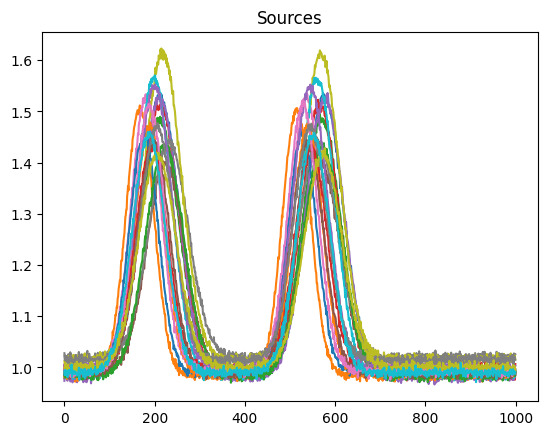

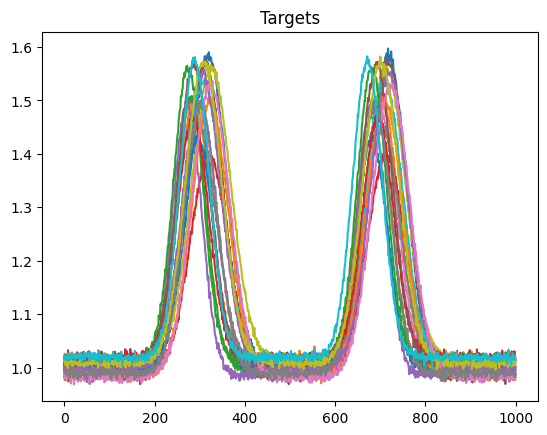

In [3]:
# Generate some samples
sources, targets = generate_samples(20, source_cue_mean_idxs=[50, 400], target_cue_mean_idxs=[150, 550])
print(sources.shape)

plt.figure()
plt.plot(sources)
plt.title('Sources')
plt.figure()
plt.title('Targets')
plt.plot(targets)
plt.show()

### 1. Data preparation
We first define the two time-series as the source and the target (As indicated above). Simply speaking, the source transmits the cue and the target receive the cue. In this demo, we attempt to find the cues transfered from the source to the target. Assuming we define $X$ as the target and $Y$ as the source, the first step is preparing the data. We use [Takens' delay embedding](https://doi.org/10.1007/BFb0091924) to create higher-dimensional embeddings for the time-history series of the target and source.
$$
    \mathbf{X}_{t}^{(d)} = (x(t-\delta), x(t-2\delta), ..., x(t-(d-1)\delta))
$$
$$
    \mathbf{Y}_{t}^{(d)} = (y(t-\delta), y(t-2\delta), ..., y(t-(d-1)\delta)) ,
$$
where $d$ denotes the history length and $\delta$ denotes the unit time step. For this demonstration, we set $d=10$ and $\delta=1$. There are two types of training data we need to prepare $(X_{t-1}, X_{t-2}, ..., X_{t-10})$ and $(X_{t-1}, X_{t-2}, ..., X_{t-10}, Y_{t-1}, Y_{t-2}, ..., Y_{t-10})$. We call them the data without communication (`NoCommDataset`) and the data with communication (`CommDataset`) respectively. But they share the same training labels $X_t$. That is, we're going to train two models: 
 1. Using only the target history to predict the target. 
 2. Using both the target and source history to predict the target.

To avoid confusion, we directly use `target(s)` and `source(s)` as the variable names instead of $X$ and $Y$ in this demo.

In [4]:
class NoCommDataset(Dataset):
  def __init__(self, targets, hist_len):
    self.ori_targets = targets.T
    self.targets = targets.flatten('F')
    self.hist_len = hist_len

  def __len__(self):
    return self.targets.shape[0]

  def __getitem__(self, idx):
    # Simple trick to handle the first few samples
    if idx < self.hist_len:
      idx += self.hist_len - idx
    x = self.targets[idx-self.hist_len:idx]
    y = self.targets[idx]
    return x, y

  def in_out_dim(self):
    return self.hist_len, 1
  
  def get_data4prediction(self):
    pred_data = []
    for sample in self.ori_targets:
      pred_sample = []
      for i in range(len(sample)):
        if i >= self.hist_len:
          pred_sample.append(sample[i-self.hist_len:i])
      pred_data.append(pred_sample)
    return np.array(pred_data)


class CommDataset(Dataset):
  def __init__(self, sources, targets, hist_len):
    self.ori_targets = targets.T
    self.ori_sources = sources.T
    self.sources = sources.flatten('F')
    self.targets = targets.flatten('F')
    self.hist_len = hist_len

  def __len__(self):
    return self.targets.shape[0]

  def __getitem__(self, idx):
    # Simple trick to handle the first few samples
    if idx < self.hist_len:
      idx += self.hist_len - idx
    x = np.concatenate((self.targets[idx-self.hist_len:idx], self.sources[idx-self.hist_len:idx]))
    y = self.targets[idx]
    return x, y
  
  def in_out_dim(self):
    return 2*self.hist_len, 1
  
  def get_data4prediction(self):
    pred_data = []
    for sid in range(self.ori_targets.shape[0]):
      target = self.ori_targets[sid]
      source = self.ori_sources[sid]
      pred_sample = []
      for i in range(len(target)):
        if i >= self.hist_len:
          pred_sample.append(np.concatenate((target[i-self.hist_len:i], source[i-self.hist_len:i])))
      pred_data.append(pred_sample)
    return np.array(pred_data)

In [5]:
# Create datasets
hist_len = 10
nocomm_dataset = NoCommDataset(targets=targets, hist_len=hist_len)
comm_dataset = CommDataset(sources=sources, targets=targets, hist_len=hist_len)
print("NoCommDataset (input, output) dimension: {}".format(nocomm_dataset.in_out_dim()))
print("CommDataset (input, output) dimension: {}".format(comm_dataset.in_out_dim()))

NoCommDataset (input, output) dimension: (10, 1)
CommDataset (input, output) dimension: (20, 1)


### 2. Modelling the target
Here, we use a very simple MLP to model the target in two ways mentioned above. The two models we called `nocomm_model` and `comm_model`. The target should be modeled as conditional Gaussian random varibles
$$
    P(\mathbf{X}_{t}|\mathbf{X}_{t}^{(d)}) \sim \mathcal{N}_{\mathbf{X}_{t}}(f(\mathbf{X}_{t}^{(d)}),f^\mathbf{\sigma}(\mathbf{X}_{t}^{(d)}))
$$
and
$$
    P(\mathbf{X}_{t}|\mathbf{X}_{t}^{(d)},\mathbf{Y}_{t}^{(d)}) \sim \mathcal{N}_{\mathbf{X}_{t}}(f(\mathbf{X}_{t}^{(d)},\mathbf{Y}_{t}^{(d)}),f^\mathbf{\sigma}(\mathbf{X}_{t}^{(d)},\mathbf{Y}_{t}^{(d)}))
$$

In [6]:
class LinearModel(torch.nn.Module):
  def __init__(self,input_dim=2,output_dim=2):
    super(LinearModel,self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim

    self.fc1 = torch.nn.Linear(input_dim,output_dim)
    self.log_sigma = torch.nn.Linear(input_dim,output_dim)
  
  def sample(self,x):
    dist = self.forward(x)
    return dist.sample()

  def get_stats(self,x):
    dist = self.forward(x)
    return dist.loc, dist.covariance_matrix

  def forward(self,x):
    mu = self.fc1(x)

    sigma = torch.exp(self.log_sigma(x))
    if self.output_dim != 1:
      cov = torch.diag_embed(sigma)
      m = MultivariateNormal(mu,cov)
    else:
      m = Normal(torch.squeeze(mu), torch.squeeze(sigma))
    return m

In [7]:
class ExampleTrainer:
    def __init__(self, dataset, model) -> None:
        self.dataset = dataset
        _, self.output_dim = dataset.in_out_dim()
        self.model = model

        self.train_set = None
        self.val_set = None
        self.train_loader = None
        self.val_loader = None

        self.epoch = 0

    def _prepare_data(self, train_val_ratio=0.8, batch_size=256) -> None:
        num_train = int(len(self.dataset)*train_val_ratio)
        torch.manual_seed(0) # Set torch's random seed so that random split of data is reproducible
        self.train_set, self.val_set = random_split(self.dataset, [num_train, len(self.dataset)-num_train])
        self.train_loader = DataLoader(self.train_set, shuffle=True, batch_size=batch_size)
        self.valid_loader = DataLoader(self.val_set, batch_size=batch_size)

        print('Number of training data:', len(self.train_set))
        print('Number of validation data:', len(self.val_set))
        sample_x, sample_y = next(iter(self.train_loader))
        print('x shape:', sample_x.shape, '\ny shape:', sample_y.shape)

    def _setup(self, max_epochs=8000, lr=1e-3, comm_type="Undefined") -> None:
        # Set hyperparameters
        self.max_epochs = max_epochs
        self.learning_rate = lr
        self.comm_type = comm_type

        self.min_avg_log_loss = 1e20
        self.min_avg_log_val_loss = 1e20

        self.min_avg_MSE_loss = 1e20
        self.min_avg_MSE_val_loss = 1e20

        # Create optimiser and MSE loss function
        self.optimiser = torch.optim.Adam(self.model.parameters(), weight_decay=1e-4, lr=self.learning_rate)
        self.MSE_loss_fn = torch.nn.MSELoss()

        # Initialise tensorboard writer
        self.timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        self.trainer_name = '{}'.format(self.comm_type)
        print("Trainer Name: ", self.trainer_name)

    def _train(self) -> None:
        self.start_time = time.time()
        for e in range(self.max_epochs):
            # Train
            self.model.train(True)
            avg_log_loss, avg_MSE_loss = self._train_one_epoch()
            if avg_log_loss < self.min_avg_log_loss:
                self.min_avg_log_loss = avg_log_loss
            if avg_MSE_loss < self.min_avg_MSE_loss:
                self.min_avg_MSE_loss = avg_MSE_loss

            # Validate
            self.model.train(False)
            avg_log_val_loss, avg_MSE_val_loss = self._validate_one_epoch()
            if avg_log_val_loss < self.min_avg_log_val_loss:
                self.min_avg_log_val_loss = avg_log_val_loss
            if avg_MSE_val_loss < self.min_avg_MSE_val_loss:
                self.min_avg_MSE_val_loss = avg_MSE_val_loss
                # Track best MSE performance, and save the model's state
                model_path = 'models/best_{}'.format(self.comm_type)
                torch.save(self.model.state_dict(), model_path)
            
            # Print loss
            elapsed = time.time() - self.start_time
            elapsed = "%02d:%02d:%02d" % (elapsed//3600, elapsed//60%60, elapsed%60)
            print('EPOCH {}: MSE LOSS train {} valid {} TIME Elapsed: {}'.format(self.epoch, avg_MSE_loss, avg_MSE_val_loss, elapsed))

            # Save checkpoint every 10 epochs
            if e % 10 == 9:
                checkpoint = {'epoch': self.epoch, 'state_dict': self.model.state_dict(), 'optimizer': self.optimiser.state_dict()}
                self._save_ckp(checkpoint, "ckps/" + self.trainer_name + ".pt")

    def _loss_fn(self, y_pred, y_true):
        if self.output_dim != 1:
          y_pred.loc = torch.squeeze(y_pred.loc)
          y_pred.covariance_matrix = torch.squeeze(y_pred.covariance_matrix)
          return torch.mean(-MultivariateNormal(y_pred.loc, y_pred.covariance_matrix).log_prob(y_true))
        else:
          y_pred.loc = torch.squeeze(y_pred.loc)
          y_pred.scale = torch.squeeze(y_pred.scale)
          return torch.mean(-Normal(y_pred.loc, y_pred.scale).log_prob(y_true))

    def _train_one_epoch(self):
        running_loss = 0.
        last_loss = 0.

        running_MSE_loss = 0.
        last_MSE_loss = 0.
        
        for inputs, labels in self.train_loader:
            inputs = torch.unsqueeze(inputs, dim=1).float()
            labels = torch.squeeze(labels.float())

            self.optimiser.zero_grad()
            outputs = self.model(inputs)

            loss = self._loss_fn(outputs, labels)
            MSE_loss = self.MSE_loss_fn(torch.squeeze(outputs.loc), labels)
            loss.backward()

            self.optimiser.step()

            running_loss += loss.item()
            running_MSE_loss += MSE_loss.item()

        last_loss = running_loss / len(self.train_loader) # loss per batch
        last_MSE_loss = running_MSE_loss / len(self.train_loader)
        self.epoch += 1

        return last_loss, last_MSE_loss
    
    def _validate_one_epoch(self):
        running_log_val_loss = 0.0
        running_MSE_val_loss = 0.0

        with torch.no_grad():
            for i, vdata in enumerate(self.valid_loader):
                vinputs, vlabels = vdata
                vinputs = torch.unsqueeze(vinputs, dim=1).float()
                vlabels = torch.squeeze(vlabels.float())
                voutputs = self.model(vinputs)
                vloss = self._loss_fn(voutputs, vlabels)
                visual_vloss = self.MSE_loss_fn(torch.squeeze(voutputs.loc), vlabels)
                running_log_val_loss += vloss
                running_MSE_val_loss += visual_vloss
            avg_log_val_loss = running_log_val_loss / (i + 1)
            avg_MSE_val_loss = running_MSE_val_loss / (i + 1)
        
        return avg_log_val_loss, avg_MSE_val_loss
    
    def _save_ckp(self, state, checkpoint_dir):
        torch.save(state, checkpoint_dir)

    def _predict(self):
        pred_X = self.dataset.get_data4prediction()
        entropy_all = []
        pred_y_all = []
        for pred_x in pred_X:
            pred_x = torch.from_numpy(pred_x).float()
            pred_y = self.model(pred_x)
            pred_y.loc = torch.squeeze(pred_y.loc)
            if self.output_dim != 1:
                pred_y.covariance_matrix = torch.squeeze(pred_y.covariance_matrix)
            else:
                pred_y.scale = torch.squeeze(pred_y.scale)
            pred_y_all.append(pred_y.loc.detach().numpy())

            entropy = []
            for i in range(pred_y.loc.shape[0]):
                if self.output_dim != 1:
                    multinorm = MultivariateNormal(loc=pred_y.loc[i], covariance_matrix=pred_y.covariance_matrix[i])
                else:
                    multinorm = Normal(loc=pred_y.loc[i], scale=pred_y.scale[i])
                entropy.append(multinorm.entropy().detach().numpy())
            entropy = np.stack(entropy)
            entropy_all.append(entropy)

        prediction = np.array(pred_y_all)
        entropy_data = np.array(entropy_all)
        return prediction, entropy_data

In [8]:
# Create models
input_dim, output_dim = nocomm_dataset.in_out_dim()
nocomm_model = LinearModel(input_dim=input_dim,output_dim=output_dim)
input_dim, output_dim = comm_dataset.in_out_dim()
comm_model = LinearModel(input_dim=input_dim,output_dim=output_dim)

In [9]:
# Initialise trainers
nocomm_trainer = ExampleTrainer(nocomm_dataset, nocomm_model)
comm_trainer = ExampleTrainer(comm_dataset, comm_model)

In [10]:
# Train model assuming no communication
nocomm_trainer._prepare_data(train_val_ratio=0.8, batch_size=256)
nocomm_trainer._setup(max_epochs=30, lr=5e-4, comm_type="NoComm")
nocomm_trainer._train()
nocomm_prediction, nocomm_entropy = nocomm_trainer._predict()

Number of training data: 16000
Number of validation data: 4000
x shape: torch.Size([256, 10]) 
y shape: torch.Size([256])
Trainer Name:  NoComm
EPOCH 1: MSE LOSS train 2.270336966665964 valid 1.792955756187439 TIME Elapsed: 00:00:00
EPOCH 2: MSE LOSS train 1.5158837144337003 valid 1.2404260635375977 TIME Elapsed: 00:00:00
EPOCH 3: MSE LOSS train 1.066395832432641 valid 0.8806596994400024 TIME Elapsed: 00:00:00
EPOCH 4: MSE LOSS train 0.7563493100423662 valid 0.6203035712242126 TIME Elapsed: 00:00:00
EPOCH 5: MSE LOSS train 0.5276294492539906 valid 0.42476242780685425 TIME Elapsed: 00:00:00
EPOCH 6: MSE LOSS train 0.3545159077833569 valid 0.27634966373443604 TIME Elapsed: 00:00:00
EPOCH 7: MSE LOSS train 0.22364956897402566 valid 0.16625860333442688 TIME Elapsed: 00:00:01
EPOCH 8: MSE LOSS train 0.1288444527557918 valid 0.08909407258033752 TIME Elapsed: 00:00:01
EPOCH 9: MSE LOSS train 0.06527675451740386 valid 0.04068461433053017 TIME Elapsed: 00:00:01
EPOCH 10: MSE LOSS train 0.027969

In [11]:
# Train model assuming communication
comm_trainer._prepare_data(train_val_ratio=0.8, batch_size=256)
comm_trainer._setup(max_epochs=30, lr=5e-4, comm_type="Comm")
comm_trainer._train()
comm_prediction, comm_entropy = comm_trainer._predict()

Number of training data: 16000
Number of validation data: 4000
x shape: torch.Size([256, 20]) 
y shape: torch.Size([256])
Trainer Name:  Comm
EPOCH 1: MSE LOSS train 0.24220231615953028 valid 0.02353125438094139 TIME Elapsed: 00:00:00
EPOCH 2: MSE LOSS train 0.021166564083643376 valid 0.01708904281258583 TIME Elapsed: 00:00:00
EPOCH 3: MSE LOSS train 0.011512397381935328 valid 0.004972899332642555 TIME Elapsed: 00:00:00
EPOCH 4: MSE LOSS train 0.0021758712994466934 valid 0.0009605049854144454 TIME Elapsed: 00:00:00
EPOCH 5: MSE LOSS train 0.0010169282017852225 valid 0.0008745422819629312 TIME Elapsed: 00:00:00
EPOCH 6: MSE LOSS train 0.0008876024798992726 valid 0.0009269794682040811 TIME Elapsed: 00:00:01
EPOCH 7: MSE LOSS train 0.000784963444207928 valid 0.0007223822758533061 TIME Elapsed: 00:00:01
EPOCH 8: MSE LOSS train 0.0006873421334025879 valid 0.0007048493716865778 TIME Elapsed: 00:00:01
EPOCH 9: MSE LOSS train 0.0006166294887883677 valid 0.0006660207873210311 TIME Elapsed: 00:0

### 3. Computing transfer entropy
[Transfer entropy](https://doi.org/10.1103/PhysRevLett.85.461) $(T_{Y\rightarrow X})$ can be defined as the conditional mutual information between two variables, which is formulated as follows.
$$
    T_{Y\rightarrow X}^{(k,l)}(t) =I(X_t:\mathbf{Y}_{t}^{(l)}|\mathbf{X}_{t}^{(k)})=H(X_t|\mathbf{X}_{t}^{(k)})-H(X_t|\mathbf{X}_{t}^{(k)},\mathbf{Y}_{t}^{(l)}),
$$
where $I$ denotes the mutual information and $H$ Shannon’s entropy. This equation defines the information transfer from $Y$ to $X$ ,where $t$ is the time and $k$, $l$ the history length of $X$ and $Y$. The key idea of the framework is to use TE to measure the information transfer of perceptible social cues. With the models trained above, we can easily compute the transfer entropy. Here, PyTorch calculates entropy with natural logarithm. Therefore, the information content is measured in [natural unit of information (Nat)](https://en.wikipedia.org/wiki/Nat_(unit)).

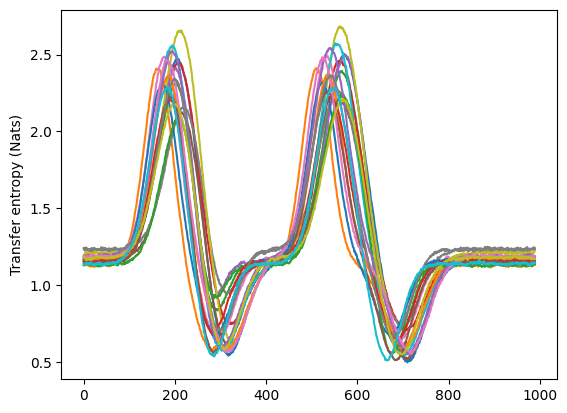

In [12]:
# Compute transfer entropy
TE_all = nocomm_entropy - comm_entropy
plt.plot(TE_all.T)
plt.ylabel('Transfer entropy (Nats)')
plt.show()

### 4. Cue detection
With the transfer entropy obtained above, cue detection is achieved by using double exponential smoothing (DES) followed by a thresholding. Let us denote $\mu_t$, $\sigma_t$ and $T_t$ as the moving mean, moving standard deviation of TE and current TE at time $t$. The DES works as follows:
$$
    \mu_t =\alpha T_t+(1+\alpha)(\mu_{t-1}+b_{t-1})
$$
$$
    \sigma_t = (1-\alpha)(\sigma_{t-1}+\alpha(T_t-\mu_{t-1}-b_{t-1})(T_t-\mu_{t-1}))
$$
$$
    b_t =\beta(T_t-x_{t-1})+(1-\beta)b_{t-1}
$$
Here, $b_t$ is the smoothed trend at time $t$, $\alpha$ is a smoothing factor and $\beta$ a trend smoothing factor. Then the perceptible cue threshold is computed as
$$
    threshold_{t} = \mu_{t-1} + \gamma\sigma_{t-1},
$$
where $\gamma$ is a tunable parameter. We use $\gamma=3$ in the work. The thresholding process filters out TE trends, which represent the accumulated information during continuous information exchanges. TE regions that meets the requirement $TE_t > 0$ and $TE_t > threshold_t$ indicate perceptible social cues. In order to further remove the effect of the trend, we apply a 1st order high-pass filter to the TE before cue detection.

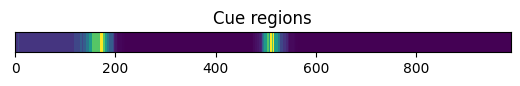

In [49]:
def double_exponential_mean_smoothing(x_t, m_t_1, b_t_1, alpha, beta):
    m_t = alpha*x_t + (1-alpha)*(m_t_1 + b_t_1)
    b_t = beta*(m_t - m_t_1) + (1-beta)*b_t_1
    return m_t, b_t

def double_exponential_std_smoothing(x_t, s_t_1, m_t_1, b_t_1, alpha):
    return (1-alpha)*(s_t_1 + alpha*(x_t-m_t_1-b_t_1)*(x_t-m_t_1))

def get_cue_regions(TE, alpha, beta, sigma):
    mean_alpha = alpha
    std_alpha = alpha
    moving_mean = [TE[0]]
    moving_std = [0]
    moving_trend = [TE[1]-TE[0]]

    for i in range(1,len(TE)):
        m_t, b_t = double_exponential_mean_smoothing(TE[i], moving_mean[-1], moving_trend[-1], mean_alpha, beta)
        moving_mean.append(m_t)
        moving_trend.append(b_t)
        s_t = double_exponential_std_smoothing(TE[i], moving_std[-1], moving_mean[-2], moving_trend[-2], std_alpha)
        moving_std.append(s_t)

    moving_mean = np.array(moving_mean)
    moving_std = np.array(moving_std)

    threshold = moving_mean + sigma*moving_std
    threshold = np.where(threshold < 0, 0, threshold)
    cue_regions = np.where(TE > threshold, 1, 0)

    return cue_regions

def double_exponential_smoothing_cue_detection(TE):
    # Process data with 1st order high-pass filter
    processed_all_TE = []
    sos = signal.butter(1, 1, 'hp', fs=1000, output='sos')
    for te in TE:
        processed_all_TE.append(signal.sosfilt(sos, te))

    # Find cue regions
    cue_regions_all = []
    for te in TE:
        cue_regions_all.append(get_cue_regions(te, alpha=0.01, beta=0.007, sigma=3))
    # Apply a filtering to highlight cue regions
    a = 0.3
    cue_regions_count = np.exp(a*np.sum(cue_regions_all, axis=0))
    return cue_regions_count


# Compute and show cue regions
cue_regions_count = double_exponential_smoothing_cue_detection(TE_all)
plt.imshow(cue_regions_count.reshape(1,-1), aspect=40, interpolation='none')
plt.yticks([])
plt.title('Cue regions')
plt.show()